In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import regularizers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier

from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import set_random_seed
from numpy.random import seed

from pandas_datareader import data as web
from pandas_datareader.google.daily import GoogleDailyReader

@property
def url(self):
    return 'http://finance.google.com/finance/historical'

GoogleDailyReader.url = url

import datetime as dt
from IPython.display import display, HTML

Using TensorFlow backend.


In [2]:
#set seeds
seed(1)
set_random_seed(2)

## Retrieve Data through Web Scraping

In [6]:
# web scrap from 1/1/2016 to the most recent day for every stock
stockNames = ['AAPL', 'GOOG', 'AVGO']

def get_stock(stock, start, end):
    return web.DataReader(stock, 'google', start, end)['Close']

stocks = []
#first stock is the target stock
for stock in stockNames:
    stocks.append(DataFrame(get_stock(stock, dt.datetime(2016, 1, 1), dt.datetime.today())))

## Data Pre-Processing

In [7]:
#size of window
num_lags = 1
#keep scalers to rescale back later
scalers = list()
#colnames to update df after windowing
colNames = list()

df = DataFrame()

for i in range(0, len(stocks)):
    # get difference between day 0 closing and day -1 closing
    stock = stocks[i] - stocks[i].shift()
    stock = stock.iloc[1:,:]
    
    #define scale to scale by
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(stock)
    scalers.append(scaler)
    
    if i == 0:
        #add the difference of target stock without lags
        df = concat([df, DataFrame(scaler.transform(stock))], axis = 1)
        colNames.append(stockNames[i]+"_0")
    
    for lag in range(1, num_lags+1):
        #windowing of size num_lags
        tmp = stock.shift(lag)
        tmp.fillna(0, inplace=True)
        tmp = DataFrame(scaler.transform(tmp))
        df = concat([df, tmp], axis = 1)
        colNames.append(stockNames[i]+"_"+str(lag))
        
#add correct names
df.columns = colNames
#add date index 
df.index = stocks[0].index[1:]

df.tail()

,AAPL_0,AAPL_1,GOOG_1,AVGO_1
Date,,,,
2017-11-13,-0.159628,-0.232641,-0.146073,NaN
2017-11-14,-0.435934,-0.159628,-0.126091,NaN
2017-11-15,-0.382963,-0.435934,-0.067065,NaN
2017-11-16,0.229778,-0.382963,-0.189711,NaN
2017-11-17,-0.195419,0.229778,0.193385,NaN


In [8]:
#define training and test size
training_size = int(len(df) * 0.7)

#split into training and test sets
training_set, test_set = df.iloc[:training_size, :], df.iloc[training_size:, :]    
#split each set into predictors and label
training_input, training_output = training_set.iloc[:, 1:].values, training_set.iloc[:, :1].values
test_input, test_output = test_set.iloc[:, 1:].values, test_set.iloc[:, :1].values
# add extra row into test_input to predict tomorrow's price
test_input = np.concatenate((test_input, test_set.iloc[-1:, :-1].values))
#reshape input of the LSTM to be format [samples, time steps, features]
training_input = training_input.reshape(training_input.shape[0], 1, training_input.shape[1])
test_input = test_input.reshape(test_input.shape[0], 1, test_input.shape[1])
#ensure that training_input is a multiple of batch_size
batch_size = 28
training_input_1 = training_input
training_output_1 = training_output
while (len(training_input_1) % batch_size != 0):
    training_input_1 = training_input_1[1:]
    training_output_1 = training_output_1[1:]
    
num_inputs = len(stocks) * num_lags

## Model Architecture and Training

In [9]:
#define model
model = Sequential()
model.add(LSTM(2, batch_input_shape=(batch_size, training_input_1.shape[1], training_input_1.shape[2]), stateful=True, kernel_regularizer=regularizers.l2(0.03)))
model.add(Activation('tanh'))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.03)
model.compile(loss='mean_squared_error', optimizer=adam)

model.summary()

model.fit(x=training_input_1, y=training_output_1, epochs=500, batch_size=batch_size, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (28, 2)                   48        
_________________________________________________________________
activation_1 (Activation)    (28, 2)                   0         
_________________________________________________________________
dense_1 (Dense)              (28, 1)                   3         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
308/308 [==============================] - 0s - loss: 0.1020     
Epoch 2/500
308/308 [==============================] - 0s - loss: 0.0446     
Epoch 3/500
308/308 [==============================] - 0s - loss: 0.0392     
Epoch 4/500
308/308 [==============================] - 0s - loss: 0.0362     
Epoch 5/500
308/308 [==============================] - 0s - loss: 0.0363     
Epoch 6/500
308/308 

308/308 [==============================] - 0s - loss: 0.0350     
Epoch 96/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 97/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 98/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 99/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 100/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 101/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 102/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 103/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 104/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 105/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 106/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 107/500
308/308 [==============================] - 0

308/308 [==============================] - 0s - loss: 0.0350     
Epoch 198/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 199/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 200/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 201/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 202/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 203/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 204/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 205/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 206/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 207/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 208/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 209/500
308/308 [==============================]

308/308 [==============================] - 0s - loss: 0.0350     
Epoch 300/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 301/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 302/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 303/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 304/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 305/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 306/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 307/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 308/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 309/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 310/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 311/500
308/308 [==============================]

308/308 [==============================] - 0s - loss: 0.0350     
Epoch 402/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 403/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 404/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 405/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 406/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 407/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 408/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 409/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 410/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 411/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 412/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 413/500
308/308 [==============================]

## Training Outcome

In [10]:
#predict outcome using only batch size = 1
new_batch_size = 1
#get weights of trained model
weights = model.get_weights()
#build new model and set weights
new_model = Sequential()
new_model.add(LSTM(2, batch_input_shape=(new_batch_size, training_input.shape[1], training_input.shape[2]), stateful=True, kernel_regularizer=regularizers.l2(0.03)))
new_model.add(Activation('sigmoid'))
new_model.add(Dense(1))
new_model.set_weights(weights)

adam = optimizers.Adam(lr=0.03)
new_model.compile(loss='mean_squared_error', optimizer=adam)

training_predictions = new_model.predict(training_input, batch_size=new_batch_size)
training_predictions = scalers[0].inverse_transform(training_predictions)

for i in range(len(training_input)):
    training_predictions[i][0] += stocks[0].iloc[i:i+1,:].values[0][0]
    
rmse = sqrt(mean_squared_error(stocks[0].iloc[:training_size, :].values, training_predictions))
print('Training RMSE: %.4f' % rmse)

Training RMSE: 0.1711


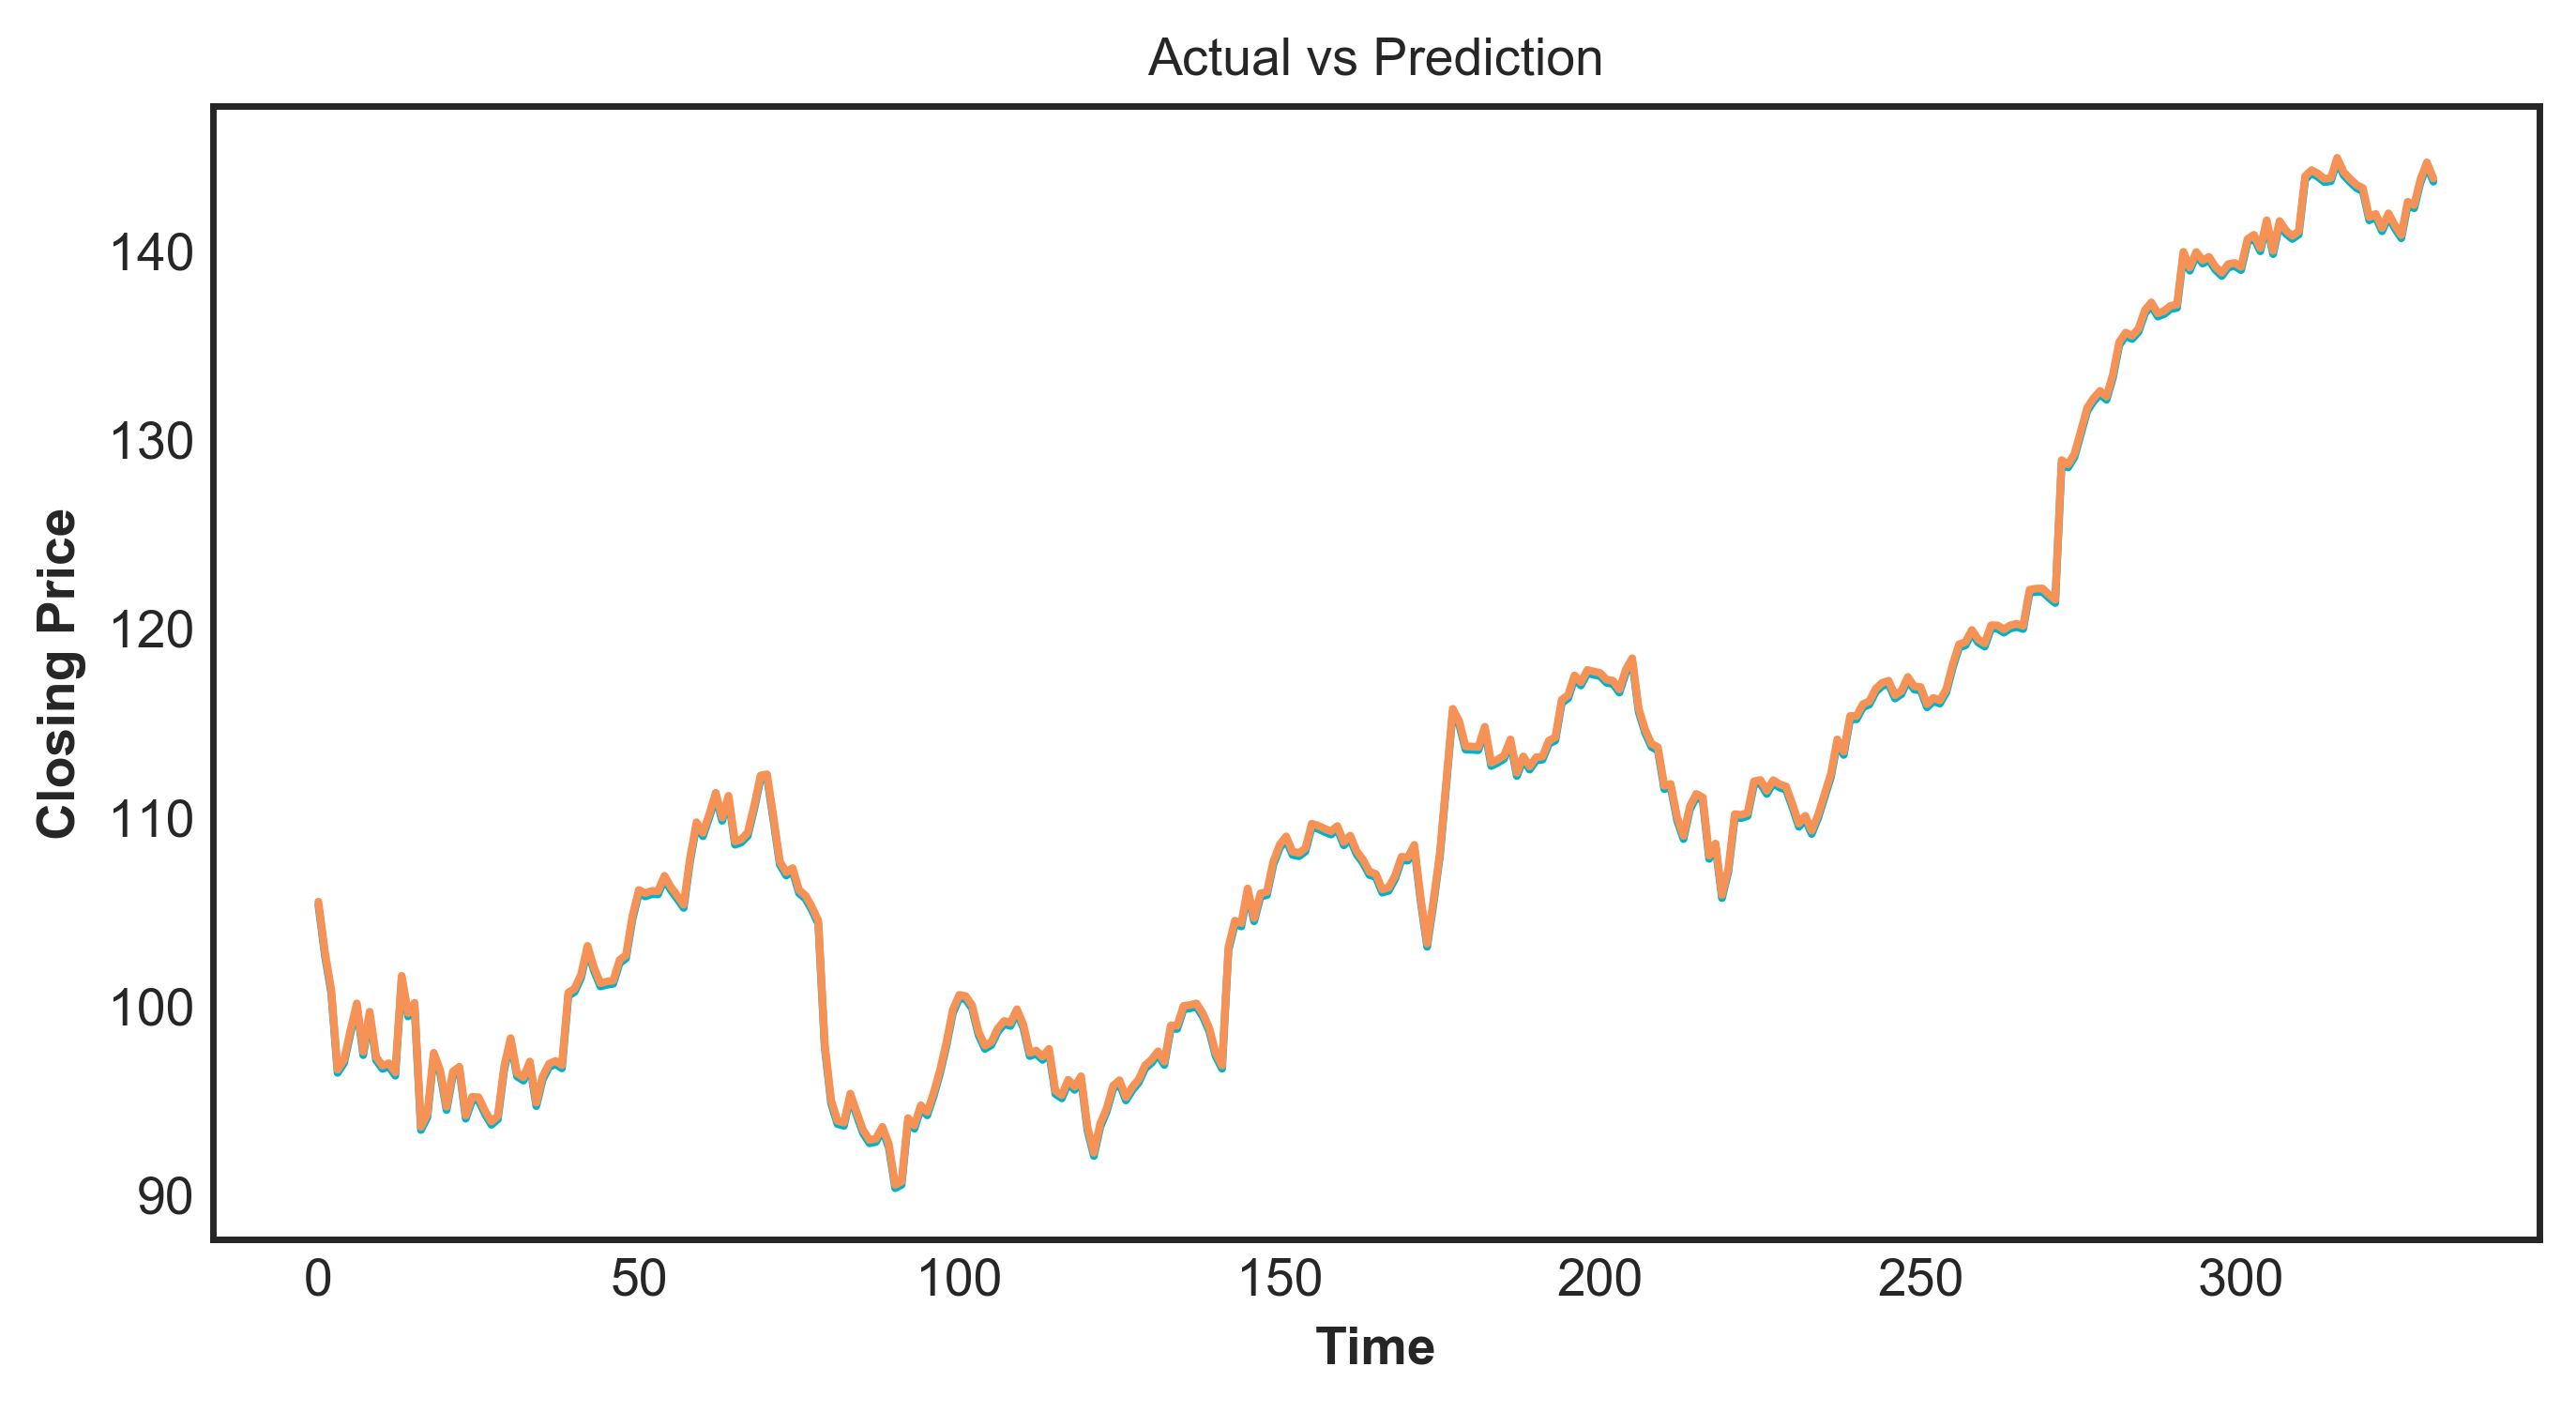

In [13]:
# training_predictions = np.concatenate((np.full((num_lags, 1), training_predictions[0]), training_predictions))
plt.style.use('seaborn-white')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Set an aspect ratio
width, height = plt.figaspect(0.5)
fig = plt.figure(figsize=(width,height), dpi=400)

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Prediction')
plt.plot(stocks[0].iloc[:training_size, :].values, color = "#00b3ca", label='Actual')
plt.plot(training_predictions, color = "#f69256", label='Prediction')
plt.show()

## Test Outcome

In [14]:
test_predictions = new_model.predict(test_input, batch_size=new_batch_size)
test_predictions = scalers[0].inverse_transform(test_predictions)

for i in range(training_size, len(df)+1):
    test_predictions[i-training_size][0] += stocks[0].iloc[i:i+1,:].values[0][0]

rmse = sqrt(mean_squared_error(stocks[0].iloc[training_size+1:, :].values, test_predictions[:-1]))
print('Test RMSE: %.4f' % rmse)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

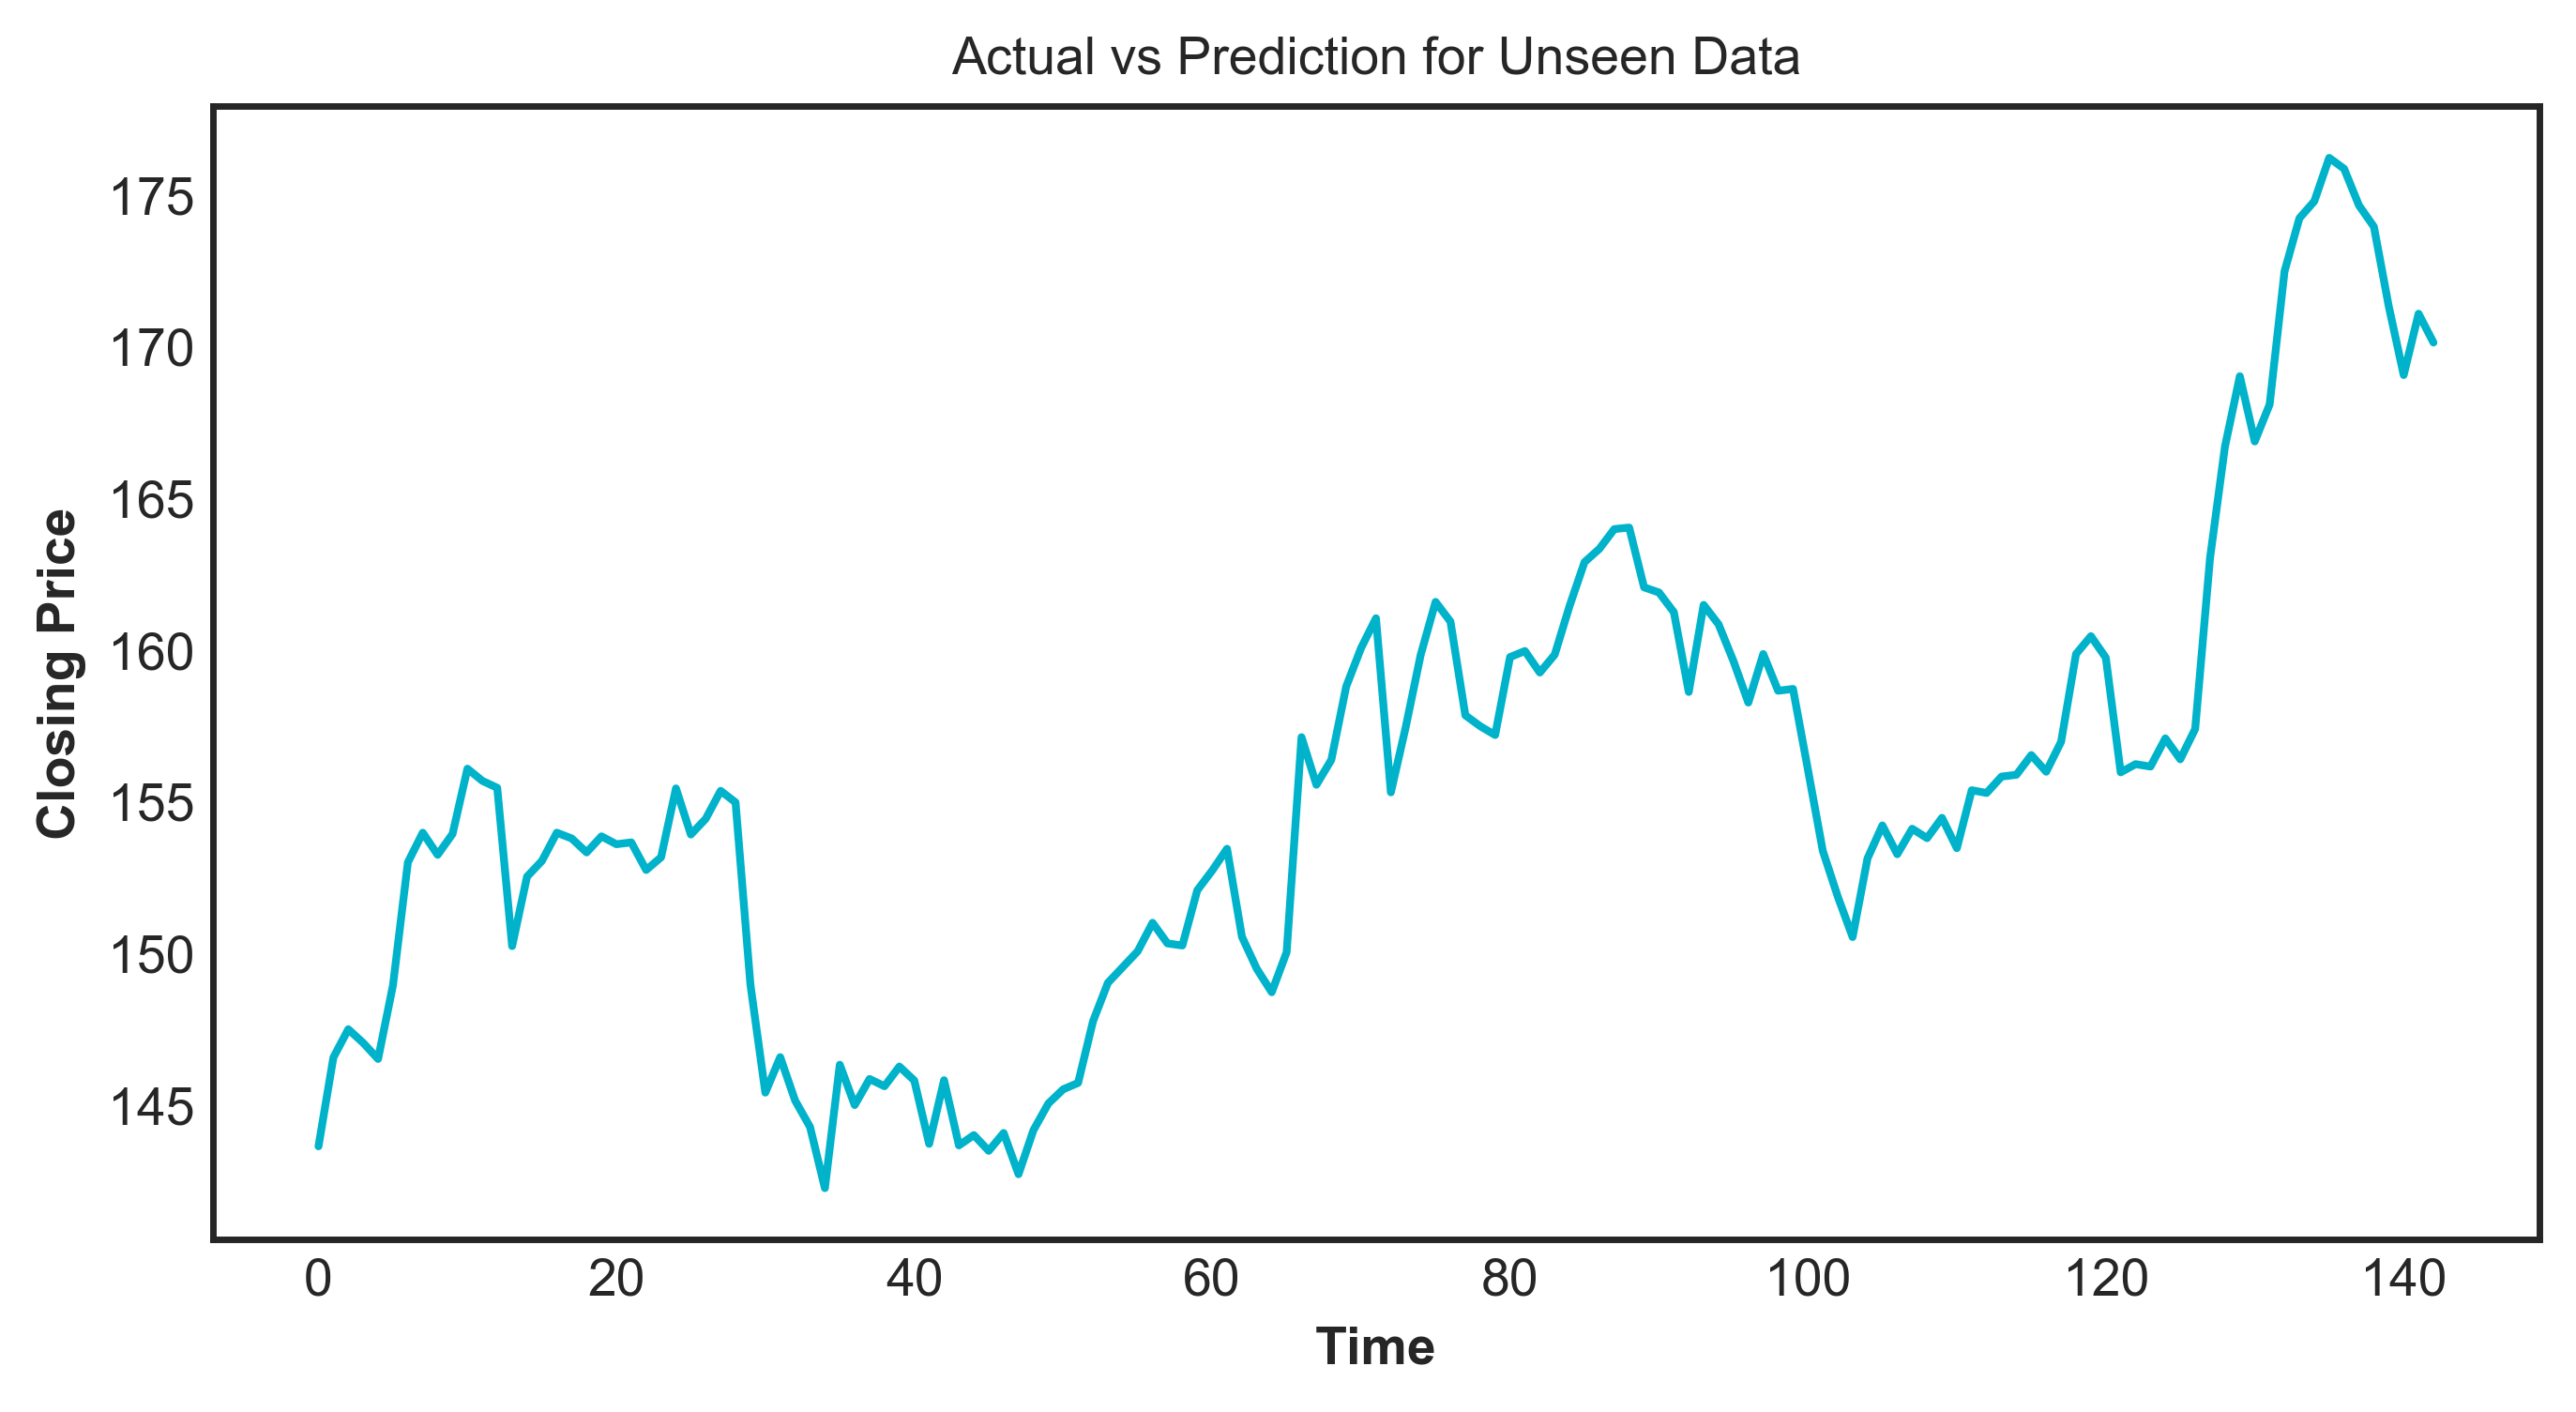

In [15]:
# test_predictions = np.concatenate((np.full((num_lags, 1), test_predictions[0]), test_predictions))
plt.style.use('seaborn-white')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Set an aspect ratio
width, height = plt.figaspect(0.5)
fig = plt.figure(figsize=(width,height), dpi=400)

plt.plot(stocks[0].iloc[training_size+1:, :].values, color = "#00b3ca",label='Actual')
plt.plot(test_predictions, color = "#f69256", label='Prediction')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Prediction for Unseen Data')
plt.show()

## Forecasted Price

In [86]:
test_predictions[-1][0]

170.34366